## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [16]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
keep_left_fit = []
keep_right_fit = []
keep_left_fitx = []
keep_right_fitx = []
keep_ploty= [] 
keep_leftx = []
keep_lefty = [] 
keep_rightx = []
keep_righty = []
# This functions apply the color and gradient threshold to the image
def color_gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary,combined_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient=='x':
        #derivate in x axis
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient=='y':
        #derivate in y axis
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2) 
    
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    #binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

def gen_warp_points(image):
    # Get image shape/size
    imshape = image.shape
    
    
    corners = np.float32([[imshape[1]*0.198, imshape[0]*.968], [imshape[1]*0.457,\
                                imshape[0]*0.635], [imshape[1]*0.547, imshape[0]*0.6333],\
                          [imshape[1]*.829,imshape[0]*.958]])


    top_left = np.array([corners[0, 0], 0])
    top_right = np.array([corners[3, 0], 0])
    offset = [60, 0]
    
    
    
    # Map source points and destination points into new array
    src_points = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst_points = np.float32([corners[0] + offset, top_left + offset, top_right - offset, corners[3] - offset])

    
    return src_points, dst_points

def birdseye_view(img, src, dst, image_size):
    # Get perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp perspective
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    # get the destination perspective
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,Minv

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    global left_fit 
    global right_fit 
    
    if len(left_fit) == 0 or len(right_fit) == 0:
        # Get the lane pixels from find_lane_pixels
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            left_fit = left_fitx
            right_fit = right_fitx
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            left_fit = left_fitx
            right_fit = right_fitx

        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
#         left_fit = []
#         right_fit = []
    else:
        try:
            out_img,left_fitx,right_fitx,ploty,leftx, lefty, rightx, righty = \
                search_around_poly(binary_warped, left_fit, right_fit)
            left_fit = left_fitx
            right_fit = right_fitx
            
        except:
            left_fit = []
            right_fit = []
            out_img = []
            return fit_polynomial(binary_warped)
        

    return out_img,left_fitx,right_fitx,ploty,leftx, lefty, rightx, righty

def fit_poly(img, leftx, lefty, rightx, righty):
    #Fit a second order polynomial to each with np.polyfit()
    #print(rightx)
    #print(righty)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    
    #width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    #Set the area of search based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
#     return result

    return out_img,left_fitx,right_fitx,ploty,leftx, lefty, rightx, righty

def measure_curvature_pixels(leftx, lefty, rightx, righty, left_fitx, right_fitx,warped_image):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    

    # Fit a second order polynomial to pixel positions in each lane line
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    

    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center - warped_image.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    
    return left_curverad, right_curverad, center_diff, side_pos

def draw_lane_lines(warped, ploty, left_fitx, right_fitx, undistorted_image, \
                    Minv,left_curverad, right_curverad, center_diff, side_pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    # Add text to image
    curvature_info = "Curvature: Left = " + str(np.round(left_curverad, 2)) + "m, Right = " + str(np.round(right_curverad, 2))+"m"
    font = cv2.FONT_HERSHEY_SIMPLEX   
    cv2.putText(result, curvature_info, (50, 50), font, 1, (255,255,255), 2)
    
    deviation_info = "Vehicle is {:.2f}m {:s} of center ".format(center_diff, side_pos) 
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, deviation_info, (50, 100), font, 1, (255,255,255), 2)
    
    return result
    
    
def process_frame(image):
    
    global keep_left_fit 
    global keep_right_fit 
    global keep_left_fitx 
    global keep_right_fitx 
    global keep_ploty 
    global keep_leftx
    global keep_lefty  
    global keep_rightx 
    global keep_righty 
    undistorted_image = undistort_image(image, objpoints, imgpoints)
    _, binary_image_threshold = color_gradient_threshold(undistorted_image)
    
    src, dst = gen_warp_points(image)
    
    binary_warped, Minv = birdseye_view(binary_image_threshold, src, dst, (image.shape[1], image.shape[0]))
    
    
    
    out_img,left_fitx,right_fitx,ploty, leftx, lefty, rightx, righty= fit_polynomial(binary_warped)
    
    left_curverad, right_curverad, center_diff, side_pos = \
        measure_curvature_pixels(leftx, lefty, rightx, righty, left_fitx, right_fitx,binary_warped)
    
    #Check if the lane line make sense
    if center_diff > 0:
        keep_left_fitx = left_fitx
        keep_right_fitx = right_fitx
        keep_ploty= ploty 
        keep_leftx = leftx
        keep_lefty = lefty 
        keep_rightx = rightx
        keep_righty = righty
    else:
        print("hit here")
        #use the kept values
        left_fitx = keep_left_fitx
        right_fitx = keep_right_fitx
        ploty= keep_ploty 
        leftx = keep_leftx
        lefty = keep_lefty 
        rightx = keep_rightx
        righty = keep_righty
        #calculate the curvature again
        left_curverad, right_curverad, center_diff, side_pos = \
            measure_curvature_pixels(leftx, lefty, rightx, righty, left_fitx, right_fitx,binary_warped)
        
        
    
    result_frame = draw_lane_lines(binary_warped, ploty, left_fitx, right_fitx,\
                               undistorted_image, Minv, left_curverad, right_curverad, center_diff, side_pos)

    return result_frame
        
    
    


In [2]:
def undistort_image(img, objectpoints, imagepoints):
    # Get image size
    img_size = (img.shape[1], img.shape[0])
    # Calibrate camera using the objectpoints, imagepoints, and image size
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, img_size, None, None)
    
    # Call cv2.undistort mnethod
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## First, I'll compute the camera calibration using chessboard images

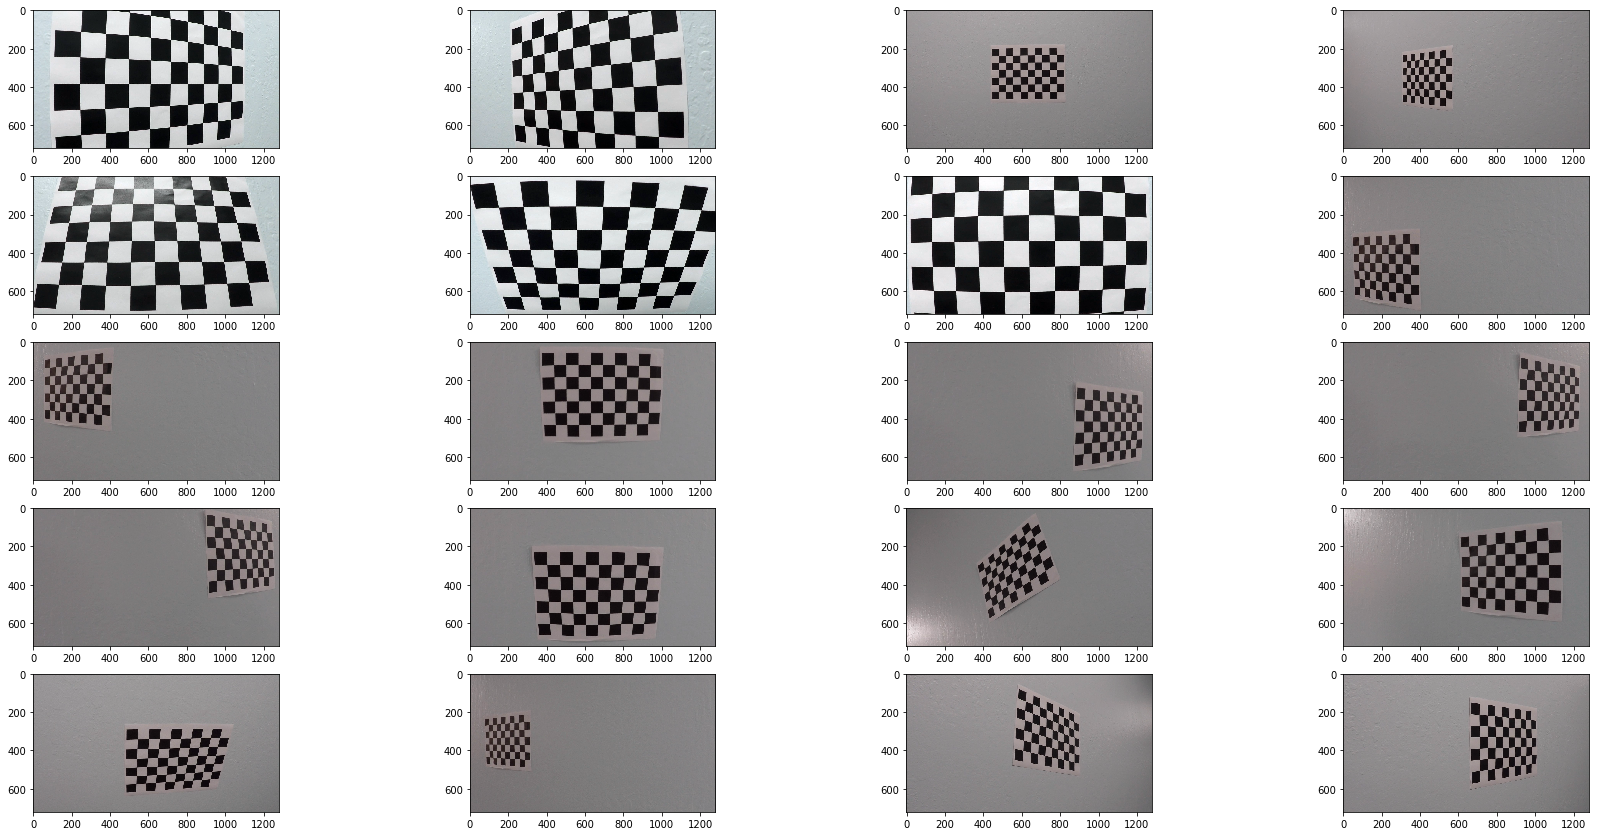

In [3]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

plt.figure(figsize=(30, 30))

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    plt.subplot(len(images)//2, 4, i+1)
    plt.imshow(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        

## Undistort Camera Image
I will use the objpoints and the imgpoints aboove to undistort an example of a distorted camera image.

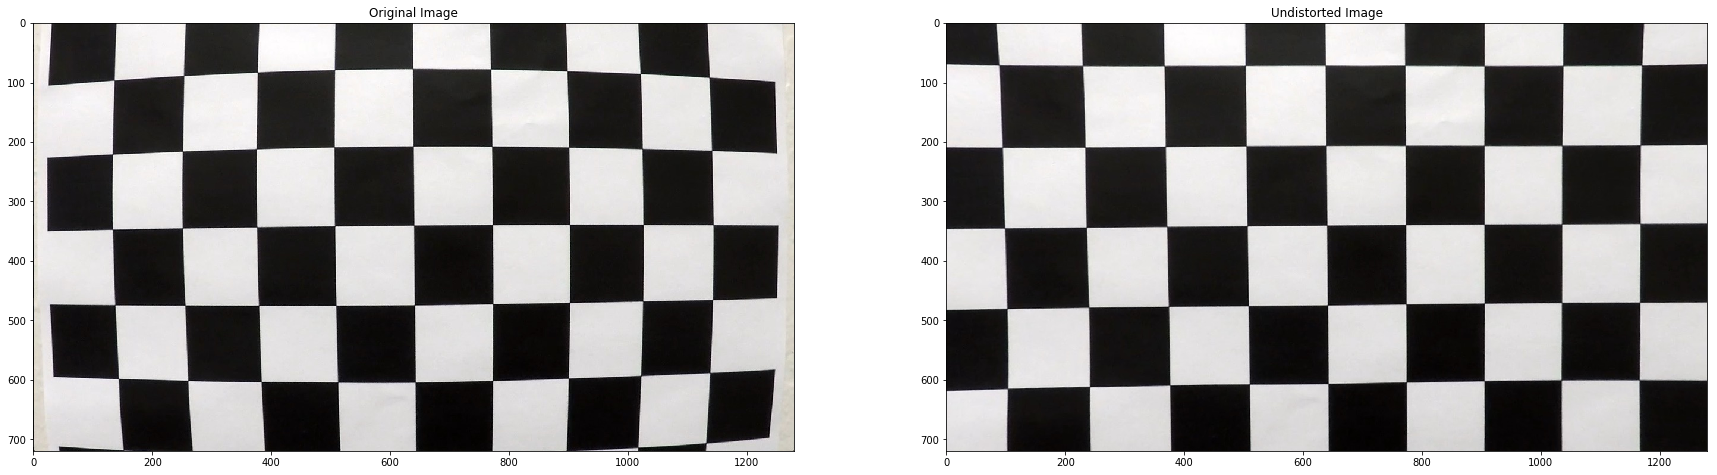

In [4]:
# Read an image 
img = cv2.imread("../camera_cal/calibration1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Undistort the given image with object points and image points
dst = undistort_image(img, objpoints, imgpoints)

# Plot before the undistortion
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

# Plot after the undistortion
plt.subplot(1, 2, 2)
plt.imshow(dst)
plt.title("Undistorted Image");

plt.savefig('../output_images/undistort_output.png')


## Combined Thresholds
I am using the combination of the ads_sobel_thresh, mag_thresh, and dir_threshold on the road image


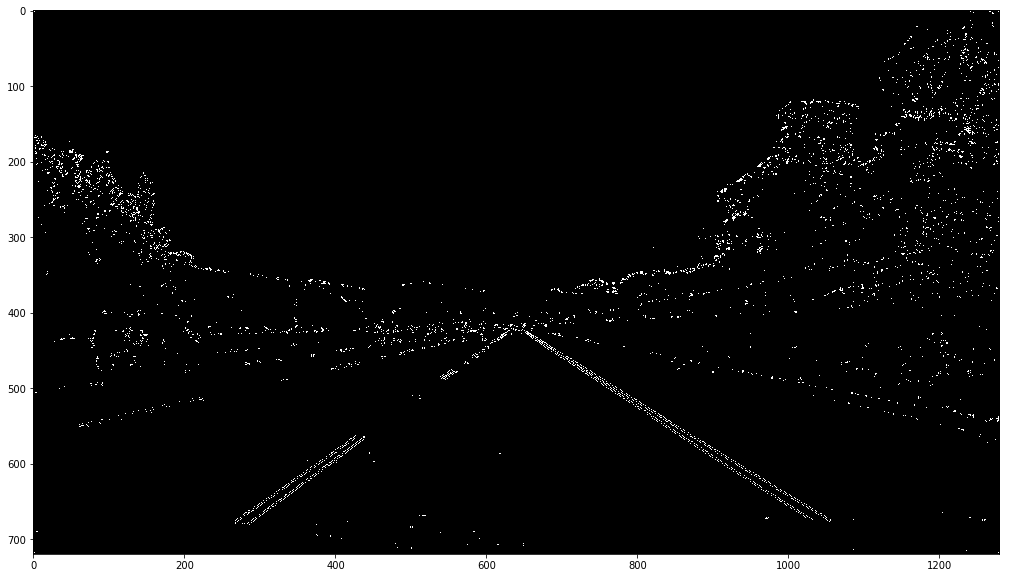

In [5]:
# Read in an image
image = cv2.imread("../test_images/straight_lines2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Undistort the given image with object points and image points
dst = undistort_image(image, objpoints, imgpoints)

# Setting the Sobel kernel size
ksize = 3 

# Applying each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x',sobel_kernel=ksize,  thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(100, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined_binary = np.zeros_like(dir_binary)

combined_binary[((dir_binary == 1) & (grady == 1) & (gradx == 1)) | ((mag_binary == 1) & (gradx == 1)) & (grady == 1)] = 1


plt.figure(figsize=(30,10))
plt.imshow(combined_binary,cmap='gray')
plt.savefig('../output_images/binary_combo_example.png')

## Color and Gradient Thresholds
I am combining the color and gradient thresholding here to get the best results


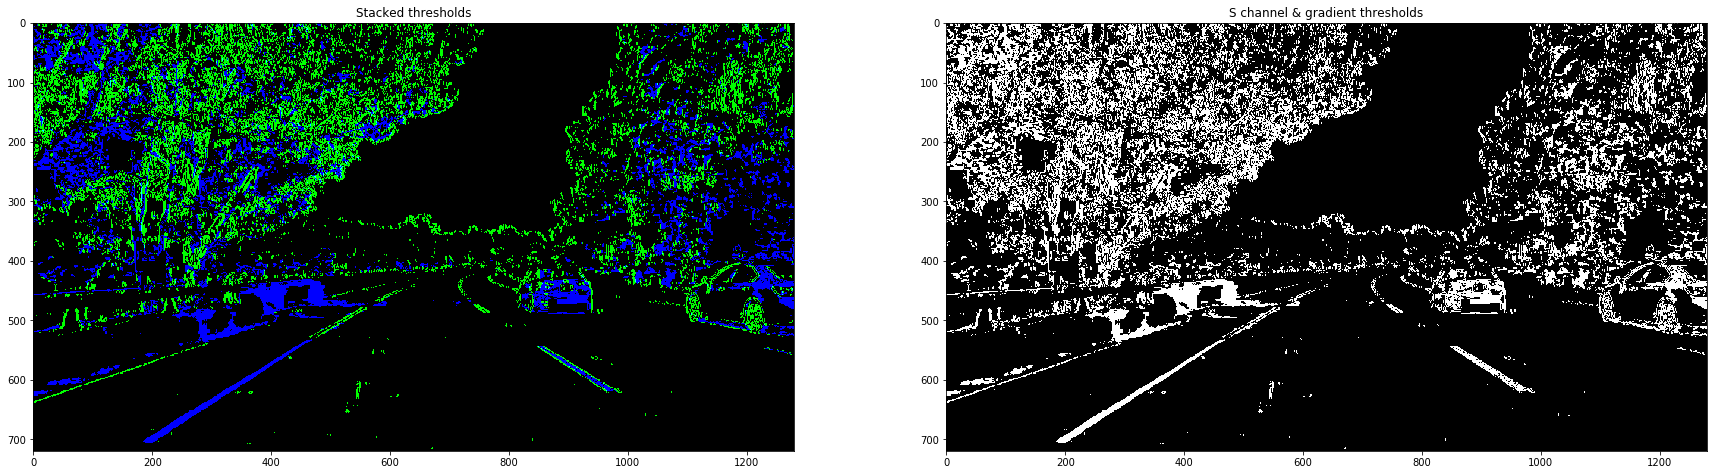

In [6]:
# Read in an image
image = cv2.imread("../test_images/test5.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Undistort the given image with object points and image points
undistorted_image = undistort_image(image, objpoints, imgpoints)

colored_binary, binary_image_threshold = color_gradient_threshold(undistorted_image, s_thresh=(170, 255), sx_thresh=(20, 100))


# Plot Stacked thresholds
plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.imshow(colored_binary)
plt.title("Stacked thresholds")

# Plot S channel & gradient
plt.subplot(1, 2, 2)
plt.imshow(binary_image_threshold,cmap='gray')
plt.title("S channel & gradient thresholds");



# Save image
plt.savefig('../output_images/combined_binary.png')

## Perspective Transform


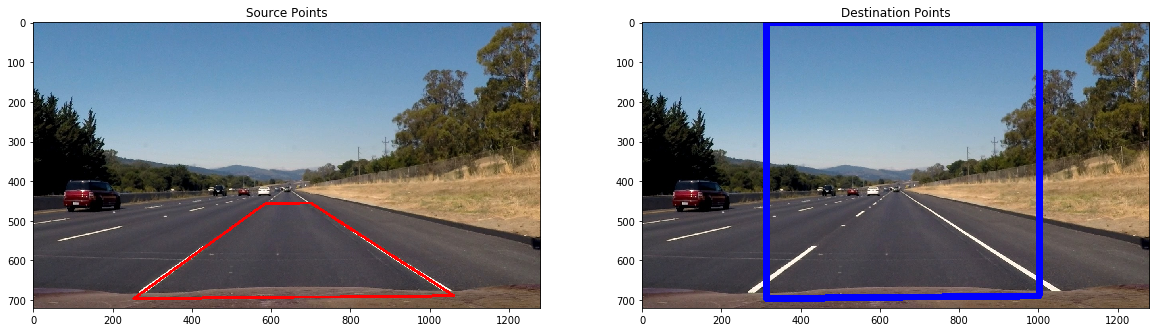

In [7]:
# Get warp points from image
image = cv2.imread("../test_images/straight_lines2.jpg")
src, dst = gen_warp_points(image)

# Make a copy of the image to draw source and destination points on
image_src_locations = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_dst_locations = image_src_locations.copy()

# Make a polygon based on source points and draw it on the image
src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(image_src_locations, [src_pts], True, (255, 0, 0), thickness=5)

# Plot source image
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image_src_locations)
plt.title("Source Points")

# Make a polygon based on destination points and draw it on the image
dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(image_dst_locations, [dst_pts], True, (0, 0, 255), thickness=15)

# Plot destination image
plt.subplot(1, 2, 2)
plt.imshow(image_dst_locations)
plt.title("Destination Points")

# Save image
plt.savefig('../output_images/perspective_transform.png')






# Example of Warped Image to Bird's-eye view

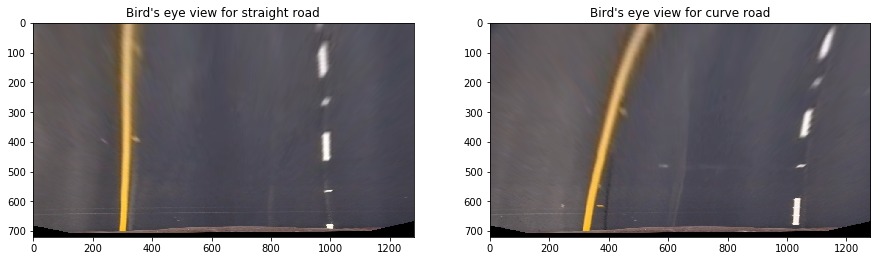

In [8]:
# Read image
image = cv2.imread("../test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#undistort image
image = undistort_image(image, objpoints, imgpoints)
#get warp points
src, dst = gen_warp_points(image)
warped,_= birdseye_view(image, src, dst, (image.shape[1], image.shape[0]))

# Plot bird's-eye view for straight road
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.imshow(warped)
plt.title("Bird's eye view for straight road");

# for curve lane
image2 = cv2.imread("../test_images/test3.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Warp curved road image into bird's-eye view
image2 = undistort_image(image2, objpoints, imgpoints)
warped2,_= birdseye_view(image2, src, dst, (image2.shape[1], image2.shape[0]))

# Plot curved road bird's-eye view
plt.subplot(1, 2, 2)
plt.imshow(warped2)
plt.title("Bird's eye view for curve road")

# Save image
plt.savefig('../output_images/bird-eye-view.png')




## Test the bird's-eye view with th combined_binary imnage

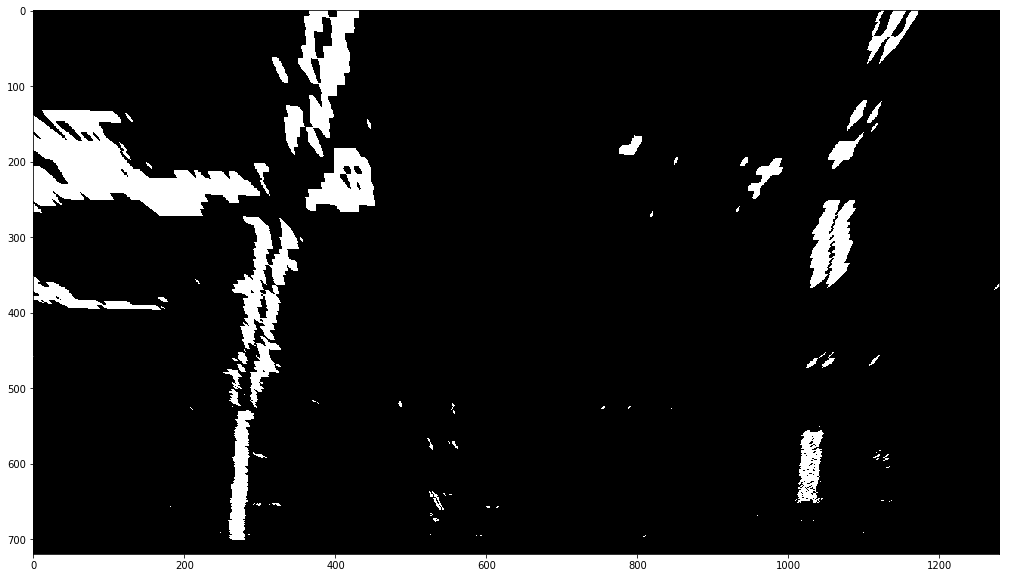

In [9]:
# Warp image to bird's-eye view and plot
warped_image,Minv= birdseye_view(binary_image_threshold, src, dst, (image.shape[1], image.shape[0]))
plt.figure(figsize=(30,10))
plt.imshow(warped_image, cmap="gray")

# Save image
plt.savefig('../output_images/binary_warped.png')

## Use the Histogram to show where the lines are in the warped image

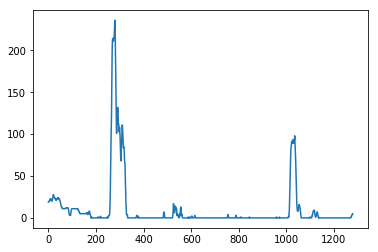

In [10]:
histogram = np.sum(warped_image[int(warped_image.shape[0]//2):,:], axis=0)
plt.plot(histogram);

## Implement Sliding Window

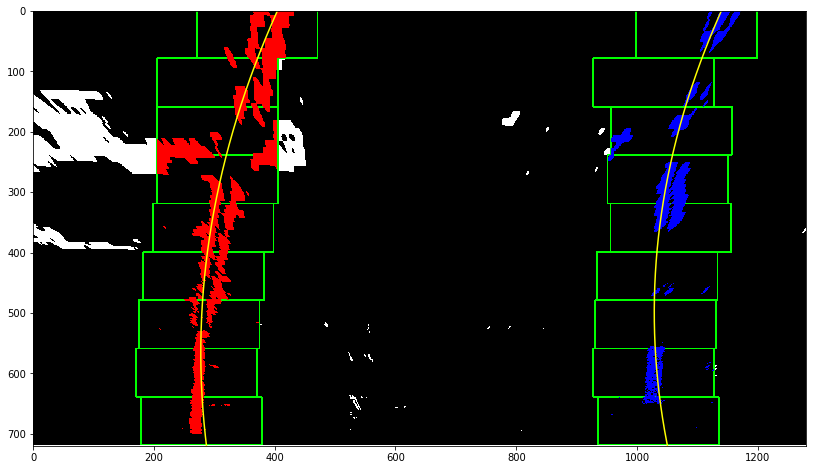

In [11]:
out_img,left_fitx,right_fitx,ploty, leftx, lefty, rightx, righty= fit_polynomial(warped_image)

# Plot the image
plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
mpimg.imsave("../output_images/color_fit_line.png",out_img)

In [12]:
left_curverad, right_curverad, center_diff, side_pos = \
    measure_curvature_pixels(leftx, lefty, rightx, righty, left_fitx, right_fitx,warped_image)
print(left_curverad,'m', right_curverad,'m', center_diff, side_pos)


414.79670256906587 m 368.3237245691734 m 0.15090062206789576 left


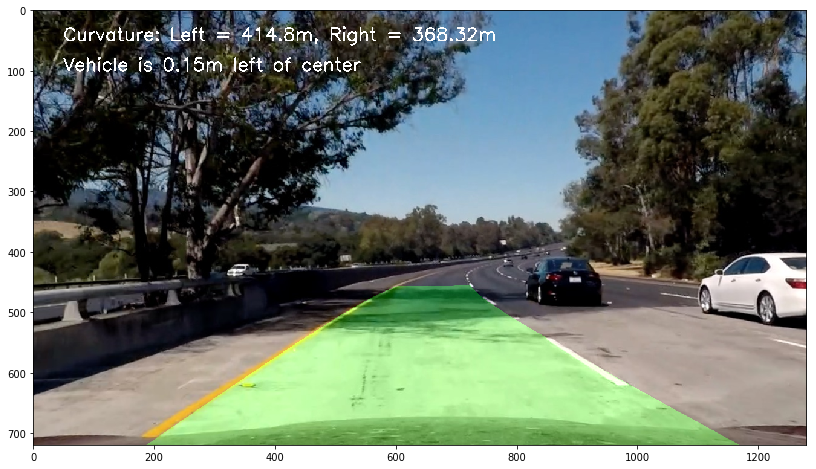

In [13]:
result_image = draw_lane_lines(warped_image, ploty, left_fitx, right_fitx,\
                               undistorted_image, Minv, left_curverad, right_curverad, center_diff, side_pos)
# Plot the image
plt.figure(figsize=(16,8))
plt.imshow(result_image)
# str(np.round(left_radius, 2))
# Save image
mpimg.imsave("../output_images/example_output.png",result_image)

In [20]:
video_output = "../output_video/project_video.mp4"
clip1 = VideoFileClip("../project_video.mp4")
clip1_output = clip1.fl_image(process_frame)
%time clip1_output.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../output_video/project_video.mp4.
Moviepy - Writing video ../output_video/project_video.mp4



Moviepy - Done !
Moviepy - video ready ../output_video/project_video.mp4
CPU times: user 16min 54s, sys: 32 s, total: 17min 26s
Wall time: 16min 48s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))